# Machine learning pour données médicales

## Prédiction du degré de démence d'une personne agée

Caro Alexandre, Balendran Alan.

Mars 2020

## Table des matières

1. [Présentation du dataset](#part1)

1. [Traitement des données](#part2)

1. [Modélisation (Prédiction de Group)](#part3)

1. [Modélisation (Prédiction de CDR)](#part4)

1. [Bayesian Net](#part5)

1. [Difficultés](#part6)



## Explication du sujet

Qu'est-ce-que la démence?

La démence est un syndrome dans lequel on observe une dégradation de la mémoire, du raisonnement, du comportement 
et de l’aptitude à réaliser les activités quotidiennes.
    
Bien que la démence touche principalement les personnes âgées, elle n’est pas une composante normale du vieillissement.
    
On compte 50 millions de personnes atteintes de démence dans le monde et il apparaît chaque année près de 10 millions de nouveaux cas.
    
La maladie d’Alzheimer est la cause la plus courante de démence et serait à l’origine de 60-70% des cas.
    
La démence est l’une des causes principales de handicap et de dépendance parmi les personnes âgées dans le monde.
    
La démence a des conséquences physiques, psychologiques, sociales et économiques pour les personnes atteintes de
la maladie mais aussi pour les personnels en charge des soins, les familles et la société en général.

## Présentation du dataset <a id="part1"></a>

In [1]:
import warnings;warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score

def afficheNA(data):
    total=data.isnull().sum().sort_values(ascending=False)
    percent=(data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing=pd.concat([total,percent],axis=1,keys=['Total','Pourcentage'])
    display(missing[percent>0])

Le dataset contient les données de personnes agées qui ont été diagnostiquées démentielles ou non. On étudie l'influence des différentes variables dans le caractère démentiel de la personne.

In [2]:
X2 = pd.read_csv('mri-and-alzheimers/oasis_longitudinal.csv')

150 patients, 373 visites.
72 déments lors de la première visite, 64 non-déments. 14 ont passé de non-dément à dément.

## Présentation des variables.

Variables démographiques:

-M/F: Sexe

-Age

-EDUC: years of education.

-SES: socio-economic status.

Variables cliniques:

-MMSE(mini mental state examination score), from 0 to 30.

-CDR(Clinical Dementia Rating), from 0 to 2.

Variables anatomiques:

-eTIV, estimated intracranial volume.

-nWBV, normalized whole-brain volume. Pourcentage des pixels classés comme appartenant à de la matière grise ou blanche sur l'IRM.

-ASF: Atlas scaling factor. C'est un facteur d'échelle calculé permettant d'effectuer un redimensionnement du crâne par rapport au voume relatif du cerveau dans le crâne.

Objectifs:

>Dans un premier temps nous essayerons de prédire l'état
de démence d'une personne:Cette information est présente dans l'information
`Group`
Nous verrons qu'en fait la prédiction de cette feature est chose aisée compte tenu de la feature `CDR`(moins la valeur est basse, moins la personne sera diagnostiqué de démente) .


>Ce qui nous ammenera à travailler sur la feature `CDR`


## Traitement des données <a id="part2"></a>

Effacement des variables qualitatives inutiles de description du patient:
    
-Hand, car tous les patients sont droitiers.

-MRI ID et subject ID car ils ne permettent pas de classifier.

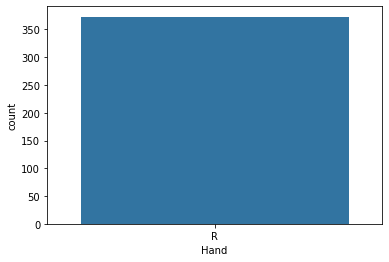

In [3]:
sns.countplot(X2['Hand']);

In [4]:
print('The number of unique value of MRI ID is {} for {} observations'.format(len(np.unique(X2['MRI ID'])),X2.shape[0]))

The number of unique value of MRI ID is 373 for 373 observations


In [5]:
X2dropped= X2.drop(['Hand','MRI ID','Subject ID'],axis=1).copy()

Remplissage des valeurs manquantes dans les variables SES et EDUC.

In [6]:
afficheNA(X2dropped)

,Total,Pourcentage
SES,19,0.050938
MMSE,2,0.005362


In [7]:
Xfilled=X2dropped.copy()
Xfilled['SES'].fillna(Xfilled['SES'].median(),inplace=True)
Xfilled['MMSE'].fillna(method='ffill',inplace=True)

In [8]:
afficheNA(Xfilled)

,Total,Pourcentage


### Label Encoding

In [9]:
from sklearn.preprocessing import LabelEncoder
cat=['Group','M/F','CDR','EDUC']
for c in cat:
    encoder=LabelEncoder()
    Xfilled[c]=encoder.fit_transform(Xfilled[c])
    Xfilled[c]=Xfilled[c].astype('category')

In [10]:
X1=Xfilled.drop(['Group'],axis=1)
Y1=Xfilled['Group']
from sklearn import preprocessing
encoder=LabelEncoder()
Y1 = encoder.fit_transform(Y1)

De plus nous transformons un problème de classification à 3 classes en un probléme de classification binaire.
En effet étant donnée que nous considérons chaque observations comme un individus unique,nous ignorons l'aspect
temporelle du jeu de données,ainsi une personne labelisé `Converted` sera considéré comme `Demented`.

In [11]:
Ybinary=Y1.copy()
Ybinary[Ybinary==0]=1
Ybinary=LabelEncoder().fit_transform(Ybinary)

Nous avons de plus départagé les données en des sous-ensembles de train et de test en faisant bien attention à ce que les données soient bien répartis entre le train et le test, pour cela on teste plusieurs niveau de découupage et on choisit le rapport tel qu'un classifieur que celui ci ne puisse pas distinguer une observation du train du split)

>Un score moyen de 0.5 sur une cross_val signifie que les données sont bien répartis entre le train/test car cela correspond à une prédiction aléatoire (pile ou face).

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
Xtr,Xte,Ytr,Yte=train_test_split(X1,Ybinary,train_size=0.5)
labels=np.concatenate((np.ones(Xtr.shape[0]),np.zeros(Xte.shape[0])))
Xall=np.r_[Xtr,Xte]
clf=LogisticRegression()
np.mean(cross_val_score(clf,Xall,labels,cv=10))

0.45003161055792634

On voit donc que les jeux d'entraînement et de test ne peuvent être facilement distingués.

## Modélisation <a id="part3"></a>
#### Group

Nous avons utilisé de nombreux modèles pour essayer d'augmenter notre score de prédiction. 
Notamment les classifieur implémenté par Sklearn:

>Logistic Regression

>Gradient Boosting

>Bagging

>Random Forest


On définit une fonction qui fit un modéle sur le train-set et renvoie le score sur test-set.

In [13]:
def modeling(models,Xt,Yt,Xte,Yte,scoring_='roc_auc'):
    [mod.fit(Xt,Yt) for mod in models.values()]
    if scoring_=='roc_auc_score':
        scores_=[roc_auc_score(Yte,mod.predict_proba(Xte)[:,1]) for mod in models.values()]
    else:
        scores_=[accuracy_score(Yte,mod.predict(Xte)) for mod in models.values()]

    df=pd.DataFrame(data=scores_,index=models.keys(),columns=['ROC-AUC'])
    df=df.sort_values(by='ROC-AUC',ascending=False)
    display(df)


In [14]:
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


bg=BaggingClassifier(random_state=70)
gb=GradientBoostingClassifier(n_estimators=5,random_state=70)
rf=RandomForestClassifier(n_estimators=45,max_depth=5,random_state=70)
lr=LogisticRegression()

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

models_={'Bagging':bg,'GradientBoosting':gb,'RandomForest':rf,'LogisiticRegresion':lr}
modeling(models_,Xtr,Ytr,Xte,Yte)

,ROC-AUC
LogisiticRegresion,0.957219
RandomForest,0.951872
Bagging,0.941176
GradientBoosting,0.941176


> Nous pouvons constater que ces modéles présentent de très bon résultats sans pour autant les tuner 

> Au début de l'analyse du dataset nous avions fait l'hypothése que la variable `CDR` soit très corréles à notre
target `Group`. Cette hypothèse se confirme lorsqu'on effectue une feature selection en utilisant la méthode 
de `Recursive Feature Elimation Cross Validation` implémenté par Sklearn

In [16]:
from sklearn.feature_selection import RFECV

selector=RFECV(gb, step=1, cv=5)
selector = selector.fit(Xtr,Ytr)
Xtr.columns[selector.get_support()]

Index(['CDR'], dtype='object')

# Modélisation <a id="part4"></a>
#### Prédiction de CDR

>Etant donnée que la prédiction de la target ne soit pas une tache difficile,nous allons maintenant nous concentrer sur la prédiction de la target 'CDR'

In [17]:
plt.style.use('ggplot')

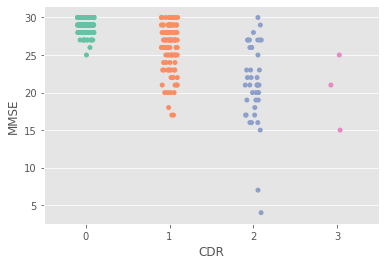

In [18]:
sns.stripplot(x='CDR',y='MMSE',data=Xfilled,palette="Set2", dodge=True);

>On peut noter que les personnes présentant une valeur de MMSE entre 20 et 30 ont moins de chance d'être diagnostiqué en tant que démente.

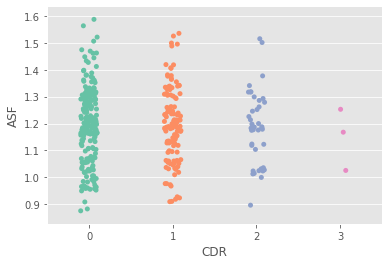

In [19]:
sns.stripplot(x='CDR',y='ASF',data=Xfilled,palette="Set2", dodge=True);

>On remarque que les données sont répartis uniformément selon les 4 labels,on remarque également que la derniére classe est sous-représenté.

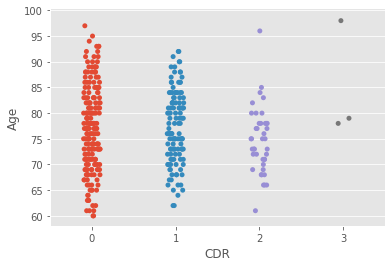

In [20]:
sns.stripplot(y='Age',x='CDR',data=Xfilled);

> L'age n'a pas vraiment l'air d'avoir un effet,on peut cependant remarquer que les personnes trés agées ont plus de risque d'être diagnostiqué en tant que personne démente.

In [21]:
Group_Cdr=pd.crosstab(index=Xfilled["CDR"],columns=Xfilled['Group'])  
Group_Cdr.index= ["0","1",'2','3']
Group_Cdr

Group,0,1,2
0,18,0,188
1,19,102,2
2,0,41,0
3,0,3,0


> Ce tableau permet de voir les relations entre `CDR` et `Group`

In [23]:
from sklearn import preprocessing

Xcdr=Xfilled.drop(['CDR'],axis=1)
Ycdr=Xfilled['CDR']

encoder=LabelEncoder()
Ycdr = encoder.fit_transform(Ycdr)

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
Xtr,Xte,Ytr,Yte=train_test_split(Xcdr,Ycdr,train_size=0.5,stratify=Ycdr)
labels=np.concatenate((np.ones(Xtr.shape[0]),np.zeros(Xte.shape[0])))
Xall=np.r_[Xtr,Xte]
clf=LogisticRegression()
np.mean(cross_val_score(clf,Xall,labels,cv=10))

0.4907539118065434

### Sélection de variables


On utilise l'élimination récursive de variables pour sélectionner les meilleures variables pour notre problème.

We use Recursive Feature Elimination in order to select the best feature for our problem

In [25]:
selector=RFECV(rf, step=1, cv=5).fit(Xcdr,Ycdr)
Xcdr.columns[selector.get_support()]

Index(['Group', 'Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE',
       'eTIV', 'nWBV', 'ASF'],
      dtype='object')

>Nous voyons que toutes les variables ont une influence dans la prédiction de la variable réponse 'CDR'

>We see that all features have a weight in order to predict `CDR`

En plus d'utiliser les modéles vues au dessus, nous testerons
d'autres modéles comme un réseau de neurones ainsi que 3
meta-models:

## Meta Models

- #### Model Averaging
> Moyenne des différents modèles

- #### Modèle convexe
> Combinaison convexe des différents modèles

- #### Schéma des K-Folds
> Moyenne d'un modèle entraîné sur plusieurs folds.



In [73]:
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

from scipy import stats
class AveragingModels(BaseEstimator, ClassifierMixin):
    
    def __init__(self, models):
        self.models = models
    def fit(self,X,Y):
        
        self.models_ = [clone(x) for x in self.models]        
        [mod.fit(X,Y) for mod in self.models_] ##fit les différents modéles
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        m = stats.mode(predictions.T) ##vote à la majorité 
        return m[0].T
    
    def score(self, X,Y):
        return accuracy_score(Y, self.predict(X))


In [74]:
class ConvexModel(BaseEstimator, ClassifierMixin):
    
    def __init__(self, models,weights=False):
        self.weights_= np.ones(len(models))/len(models) if(weights==False) else weights
        self.models_ = [clone(x) for x in models]
    
    def fit(self,X,Y):
        [mod.fit(X,Y) for mod in self.models_]##fit les différents modéles
        return self
    
    def predict(self, X):
        pred=np.zeros((X.shape[0],4))
        
        for model,w in zip(self.models_,self.weights_):
            pred=pred + model.predict_proba(X)*w ##les poids sont associés au proba prédite par les différents modéles
            
        return(np.argmax(pred,axis=1))

    def score(self, X,Y):
        return accuracy_score(Y, self.predict(X))

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
class KfoldModel(BaseEstimator, ClassifierMixin):
    
    def __init__(self, model,n_fold=3):
        self.nfold_= n_fold
        self.model_ = model
    
    def fit(self,X,Y):
        kf = KFold(n_splits=self.nfold_, shuffle=False)
        self.models_=[]
        for train_index, test_index in kf.split(X):##fit plusieurs copies d'un même modéles sur plusieurs folds 
            X_=np.asarray(X)[train_index, :]
            Y_=np.asarray(Y)[train_index]
            self.models_.append(self.model_.fit(X_,Y_))


    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        m = stats.mode(predictions.T) ##vote à la majorité
        return m[0].T
            
    def score(self, X,Y):
        return accuracy_score(Y, self.predict(X))

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation

Using TensorFlow backend.


In [30]:
class KerasNN(BaseEstimator, ClassifierMixin):
    

    def __init__(self,epochs=5,batchsize=5):
        self.epochs_= epochs
        self.batch_=batchsize
        
    def fit(self,X,Y):
        p = X.shape[1]
        targets=len(np.unique(Y))   
        Y_=keras.utils.np_utils.to_categorical(Y)
        self.nn = Sequential()
        self.nn.add(Dense(50, input_shape=(p, )))
        self.nn.add(Dense(50, activation='relu'))
        self.nn.add(Dense(50, activation='relu'))
        self.nn.add(Dense(10, activation='sigmoid'))
        self.nn.add(Dense(targets, activation='softmax'))
        self.nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        self.nn.fit(X,Y_, epochs=self.epochs_,batch_size=self.batch_,use_multiprocessing=True, verbose=0)

        return self
    
    def predict(self, X):
        return(self.nn.predict_classes(X))

    def score(self, X,Y):
        return accuracy_score(Y, self.predict(X))    

In [68]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

bg=BaggingClassifier()
gb=GradientBoostingClassifier()
rf=RandomForestClassifier()
lr=LogisticRegression()
et=ExtraTreesClassifier()
am=AveragingModels([rf,gb,bg])
cm=ConvexModel([rf,gb,bg],[0.3,0.3,0.4])
nn=KerasNN(10,50)
KfolM=KfoldModel(ExtraTreesClassifier(),3)

models_={'Bagging':bg,'GradientBoosting':gb,'RandomForest':rf,'LogisiticRegresion':lr,'ExtraTree':et,
'ModelAveraging':am,'ConvexCombination':cm,'NeuralNetwork':nn,
       'KFoldScheme':KfolM }
modeling(models_,Xtr,Ytr,Xte,Yte)

,ROC-AUC
ModelAveraging,0.887701
GradientBoosting,0.882353
ConvexCombination,0.882353
RandomForest,0.871658
ExtraTree,0.850267
Bagging,0.834225
KFoldScheme,0.828877
LogisiticRegresion,0.780749
NeuralNetwork,0.550802


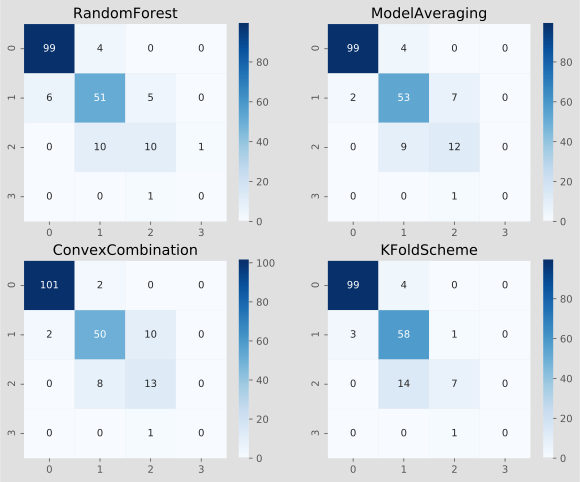

In [72]:
from sklearn.metrics import confusion_matrix
models4_={'RandomForest':rf,'ModelAveraging':am,'ConvexCombination':cm,'KFoldScheme':KfolM }

plt.figure(figsize=(10,8))
for i,(name_,mod) in enumerate(models4_.items()):
    plt.subplot(2,2,i+1)
    mod.fit(Xtr,Ytr)
    conf=confusion_matrix(Yte,mod.predict(Xte))
    sns.heatmap(conf,annot=True,cmap='Blues', fmt='g')
    plt.title(str(name_))

> We can clearly see that the three models we implemented yield better result than basic models.

In [32]:
from pylab import *
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.bn2graph as bnPlot
import pyAgrum.lib.dynamicBN as gdyn
import os

In [33]:
data=Xfilled.copy()
l=[]
for col in data.select_dtypes('float'):
    bins = np.linspace(np.min(data[col]), np.max(data[col]), 5)
    l.append(pd.DataFrame(np.digitize(data[col], bins),columns=[col]))
for col in data.select_dtypes('int'):
    bins = np.linspace(np.min(data[col]), np.max(data[col]), 5)
    l.append(pd.DataFrame(np.digitize(data[col], bins),columns=[col]))  
for col in data.select_dtypes('category'):
    l.append(pd.DataFrame(data[col],columns=[col]))  

discr_data=pd.concat(l, join='outer', axis=1)
discr_data.to_csv("mri-and-alzheimers/discr_data.csv",index=False)

In [34]:
def BayesianNet(name,learner_='Greedy'): ##create the bayesian net using Local and Greedy search for a given dataset
    learner=gum.BNLearner(name)
    learner.useLocalSearchWithTabuList() if(learner_=='Local') else learner.useGreedyHillClimbing()
    bn=learner.learnBN()
    new_name=name.split('.')
    new_name=new_name[0]+'_graph_'+learner_+'.'+new_name[1]
    bnPlot.dotize(bn,new_name,format='pdf')
    return(bn)

In [35]:
baynet1=BayesianNet("mri-and-alzheimers/discr_data.csv",learner_='Greedy')

# Bayesian Net <a id="part5"></a>

In [36]:
baynet1

(gum::BayesNet<double>@0x6aa81d0) BN{nodes: 12, arcs: 9, domainSize: 10^8.05115, dim: 205}

>`Visit` et `MR Delay` sont liées ce qui est normal compte tenu de leur définition

>`SES` et `EDUC` qui tout deux sont des variables démographiques sont également connecté,en effet on pourrait imaginer que le niveau social économique d'une personne est d'autant plus grand que son niveau d'étude soit grand (d'après le dataset).

>`CDR` et `GROUP` sont également liées comme nous l'avions supposé.

Ce réseau bayésien ne fait que confirmer les différentes relations que nous avons pu observer durant ce projet.

# Difficultés <a id="part6"></a>

> La première difficulté vient du fait que nous ne pouvions pas utiliser les données sous forme d'images(trop gros format et n'était pas au même format pour chaque patient).


> Une autre chose est que le jeu de données ne requérait pas beaucoup de pré-traitement, par conséquent nous devions travailler sur des données brutes, nous n'avons pas créé de nouvelles variables.


> L'apprentissage non supervisé ne nous a pas fourni de bons résultats.(non présent sur ce notebook mais du clustering avait été testé).


> La taille du dataset est trop petite, et nous n'avons pu tester les performances de notre modèle.
